Name: Surbhi Khatri, Github: surbhikhatri, USC ID: 9893833133

### (a) Download Data

Package imports

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

Get the Vertebral Column Data Set

In [7]:
# read data
data = arff.loadarff('../data/vertebral_column_data/column_2C_weka.arff')
df = pd.DataFrame(data[0])

In [8]:
# preprocess:
df['class'] = (df['class'] == b'Abnormal').astype(int)

### (b) Pre-Processing and Exploratory Data Analysis

#### i. Scatterplots

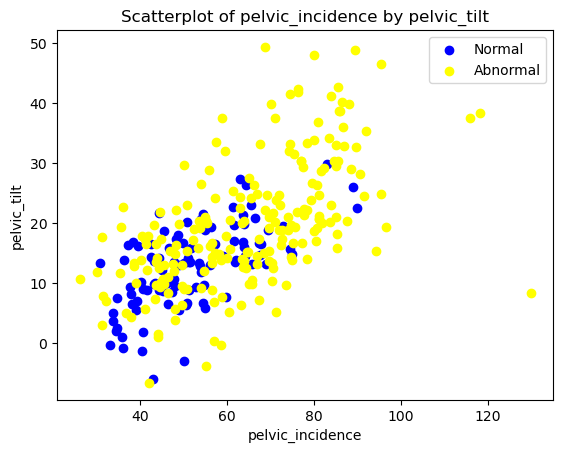

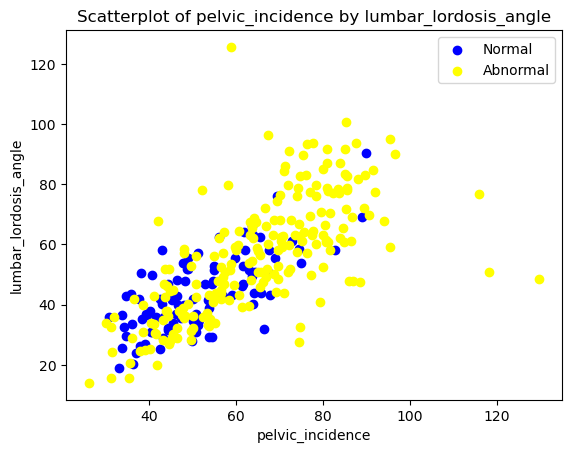

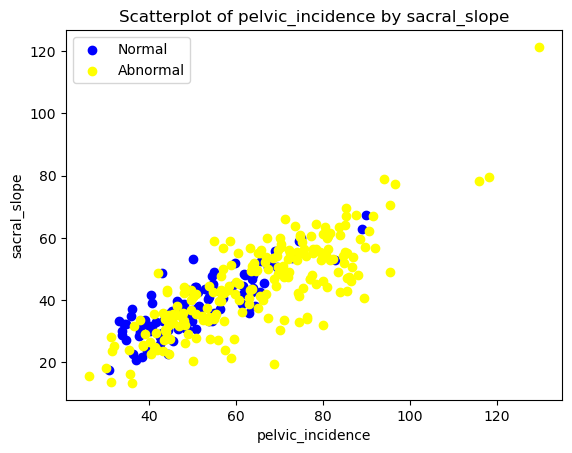

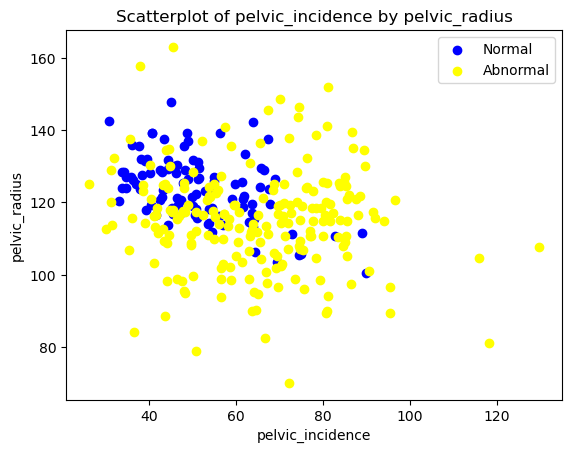

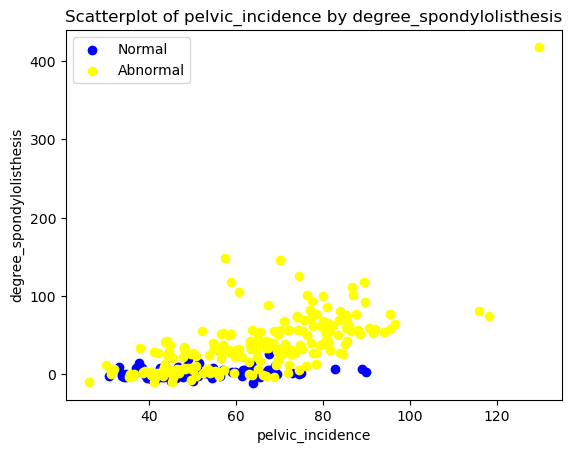

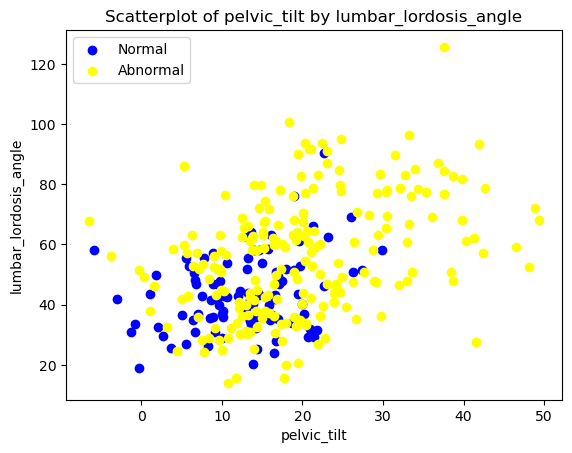

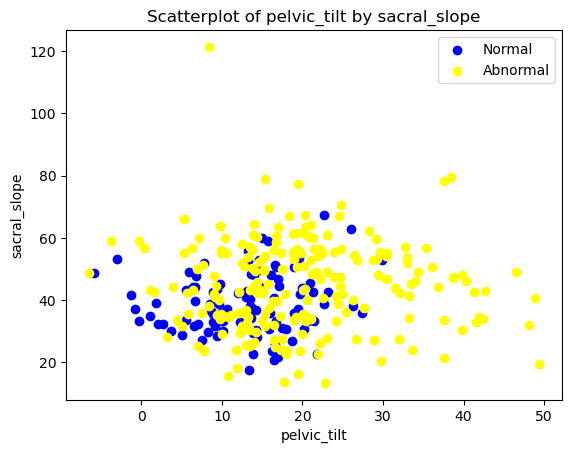

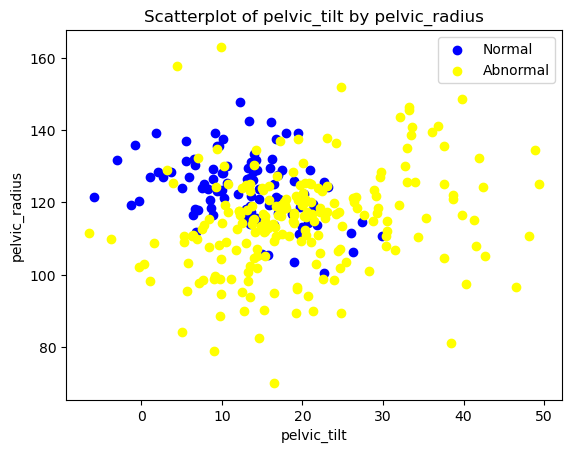

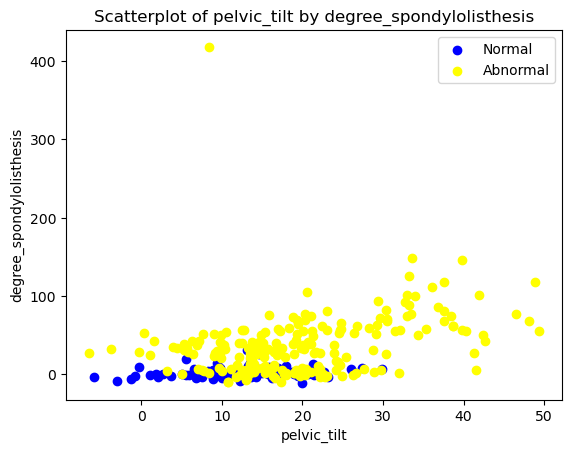

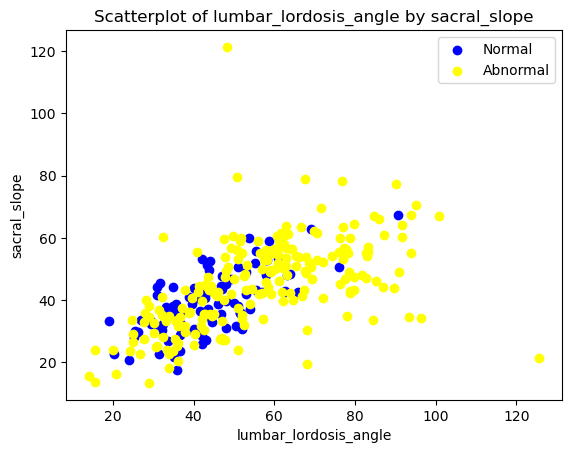

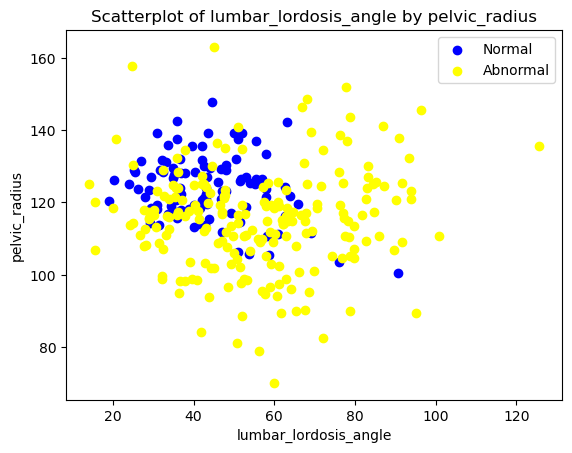

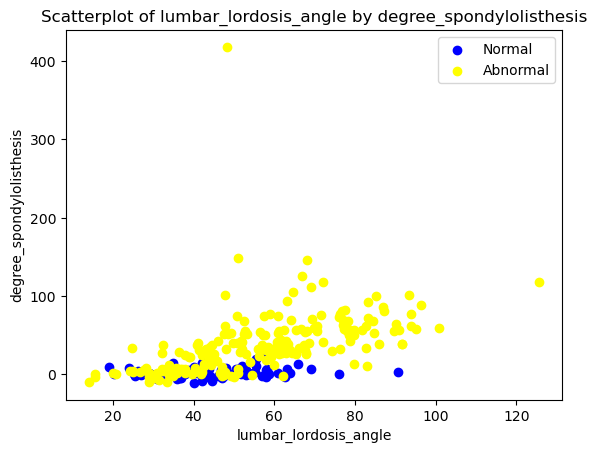

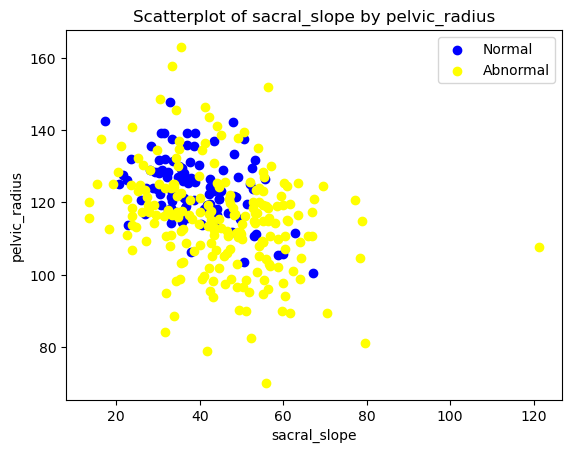

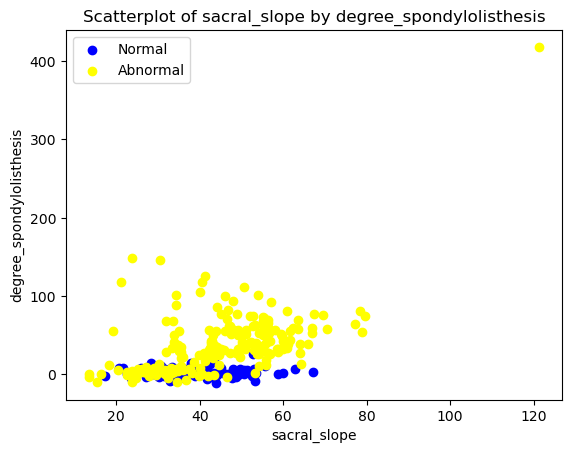

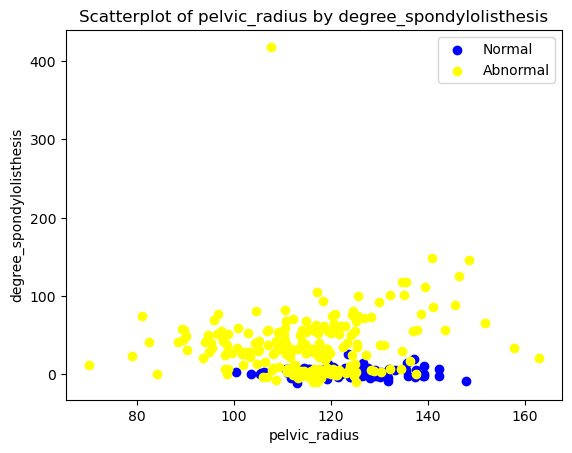

In [9]:
independent_variables = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']

for i in range(6):
    for j in range(i + 1, 6):
        a = independent_variables[i]
        b = independent_variables[j]
        if a != b:
            plt.scatter(df[df['class'] == 0][a], df[df['class'] == 0][b], label='Normal', c='blue')
            plt.scatter(df[df['class'] == 1][a], df[df['class'] == 1][b], label='Abnormal', c='yellow')
            plt.xlabel(a)
            plt.ylabel(b)
            plt.legend()
            plt.title(f'Scatterplot of {a} by {b}')
            plt.show()

#### ii. Boxplots

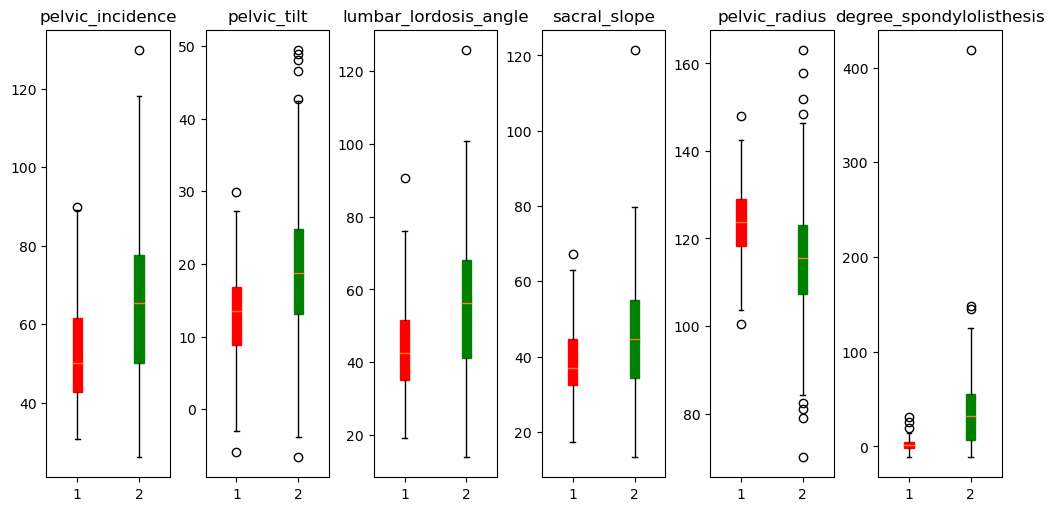

In [10]:
independent_variables = df.columns[:-1]
fig, ax = plt.subplots(1,6,constrained_layout=True, figsize=(10, 5))

for i, val in enumerate(independent_variables):
    boxplot=ax[i].boxplot([df[df['class'] == 0][val], df[df['class'] == 1][val]], patch_artist=True)
    # patch_artist is to fill the box
    boxplot['boxes'][0].set_facecolor('red')
    boxplot['boxes'][0].set_color('red')
    boxplot['boxes'][1].set_facecolor('green')
    boxplot['boxes'][1].set_color('green')
    ax[i].set_title(val)

plt.show()

#### iii. Split Data Set

In [11]:
class_0 = df[df['class'] == 0]
class_1 = df[df['class'] == 1]

train_data = pd.concat([class_0[:70], class_1[:140]])
test_data = pd.concat([class_0[70:], class_1[140:]])

### (c) Classification

#### i. Euclidean Metric

#### ii. Test Data

k* =  4


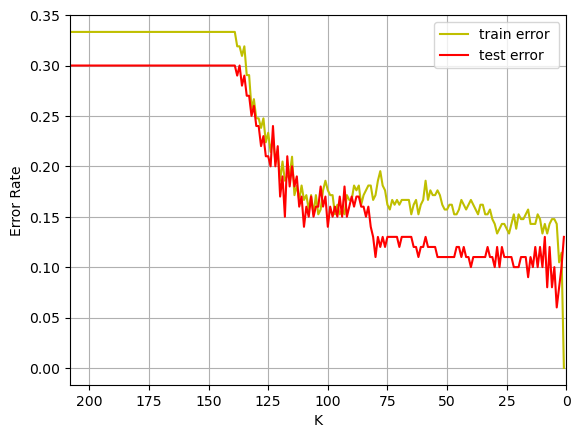

K* classification report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.93      0.99      0.96        70

    accuracy                           0.94       100
   macro avg       0.95      0.91      0.93       100
weighted avg       0.94      0.94      0.94       100

True Positive: 0.9857142857142858
True Negative: 0.16666666666666666
F1 Score: 0.9583333333333334
Precision: 0.9324324324324325
Confusion matrix:
[[25  5]
 [ 1 69]]


In [12]:
# Combining part i and ii
# by default sklearn uses euclidean distance to calculate knn

train_errors = []
test_errors = []
k_arr = [k for k in range(208, 0, -1)]

for k in range(208, 0, -1):
    knn = KNeighborsClassifier(k)
    knn.fit(train_data.drop(['class'], axis=1), train_data['class'])

    # calculate error using accuracy_score
    train_errors.append(1 - knn.score(train_data.drop(['class'], axis=1), train_data['class']))
    test_errors.append(1 - knn.score(test_data.drop(['class'], axis=1), test_data['class']))

test_error_arr = np.array(test_errors)
k_star = k_arr[np.where(test_error_arr == test_error_arr.min())[0][0]]
print("k* = ", k_star)
plt.plot(k_arr, train_errors, 'y')
plt.plot(k_arr, test_errors, 'r')
plt.grid()
plt.xlabel("K")
plt.ylabel("Error Rate")
plt.legend(['train error ','test error'])
plt.xlim(208, 0)
plt.show()

# confusion matrix, true positive, true negative, precision, F1-score for k = k_star
knn = KNeighborsClassifier(k_star)
knn.fit(train_data.drop(['class'], axis=1), train_data['class'])

print("K* classification report:")
test_pred = knn.predict(test_data.drop(['class'],axis=1))
metrics_for_k_star = classification_report(test_data['class'], test_pred)
print(metrics_for_k_star)

# manual calculation
TP = 0
TN = 0
FN = 0
FP = 0
test_actual = test_data['class']
# positive is class 1 or AB, negative is NO or 0
for i in range(len(test_pred)):
    # predicted AB but actually class NO
    if test_pred[i] == 1 and test_actual.to_xarray()[i].values != test_pred[i]:
        FP += 1
    # predicted NO but actually AB, false negative
    if test_pred[i] == 0 and test_actual.to_xarray()[i].values != test_pred[i]:
        FN += 1
    # predicted AB and actually AB, true positive
    if test_pred[i] == test_actual.to_xarray()[i].values == 1:
        TP += 1
    # predicted NO and actually NO, true negative
    if test_pred[i] == test_actual.to_xarray()[i].values == 0:
        TN += 1

print("True Positive:", TP / (TP + FN))
print("True Negative:", FP / (FP + TN))
print("F1 Score:",TP/(TP + 0.5 * (FP + FN)))
print("Precision:", TP/(TP + FP))

confusion_mat = confusion_matrix(test_data['class'], test_pred)
print("Confusion matrix:")
print(confusion_mat)

#### iii. Learning Curve

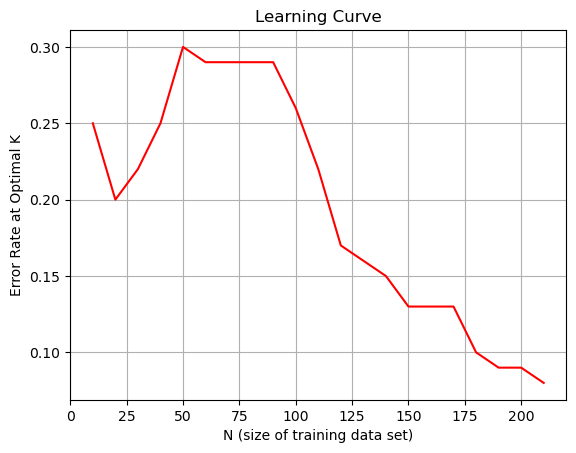

In [13]:
def get_best_error_rate(train_data_learn, test_data_learn):
    k_lower = 1
    k_top = 197
    k_step = 5
    test_error_local = []
    k_top = min(len(train_data_learn), k_top)

    for k in range(k_lower, k_top, k_step):
        knn_learn = KNeighborsClassifier(k)
        knn_learn.fit(train_data_learn.drop(['class'], axis=1), train_data_learn['class'])
        test_error_local.append(1 - knn_learn.score(test_data_learn.drop(['class'], axis=1), test_data_learn['class']))
    return min(test_error_local)

test_error_learn = []
# Vary size of training dataset by using N/3 of class 0 and N = N/3 rows of class 1
train_1 = train_data[train_data['class'] == 1]
train_0 = train_data[train_data['class'] == 0]

size_start = 10
size_end = 211
size_step = 10
# start the size N from 10 to 210, setp by 10
for i in range(size_start, size_end, size_step):
    train_size = pd.concat([train_0[:i//3], train_1[:(i-i//3)]])
    test_error_learn.append(get_best_error_rate(train_size, test_data))

plt.plot(range(size_start, size_end, size_step), test_error_learn, 'r')
plt.xlabel("N (size of training data set)")
plt.ylabel("Error Rate at Optimal K")
plt.title("Learning Curve")
plt.grid()
plt.show()

### (d) Other Metrics

#### i. Minkowski Distance.

##### A. Manhattan Distance with p = 1.

In [14]:
# using the same get_best_error_rate method as above with P values:
def get_best_error_rate(train_data_learn, test_data_learn, metric_learn, p_value):
    k_lower = 1
    k_top = 198
    k_step = 1 if metric_learn == "euclidean" else 5
    test_error_local = []
    k_top = min(len(train_data_learn), k_top)
    k_ = []
    for k in range(k_lower, k_top, k_step):
        if metric_learn == "mahalanobis":
            # Mahalanobis Distance requires inverting the covariance matrix of the data.
            train_covariance = np.cov(np.transpose(train_data_learn.drop(['class'], axis=1)), bias=False)
            knn_learn = KNeighborsClassifier(k, algorithm="auto", metric=metric_learn, metric_params={'VI': np.linalg.inv(train_covariance)})
        else:
            knn_learn = KNeighborsClassifier(k, metric=metric_learn, p=p_value)
        knn_learn.fit(train_data_learn.drop(['class'], axis=1), train_data_learn['class'])
        test_error_local.append(1 - knn_learn.score(test_data_learn.drop(['class'], axis=1), test_data_learn['class']))
        k_.append(k)
    return min(test_error_local), k_[test_error_local.index(min(test_error_local))]

    # p = 1, manhattan distance
min_error_euclidean, k_euc = get_best_error_rate(train_data, test_data, "euclidean", None)
min_error_manhattan, k_man = get_best_error_rate(train_data, test_data, "minkowski", 1)


##### B. With log10(p) in {0.1, 0.2, 0.3, ... ,1}.

In [15]:
# p = 10^0.1, 10^0.2
test_error_log_p = []
for i in range(10):
    # print(10**(i/10))
    knn_log = KNeighborsClassifier(k_man, metric="minkowski", p=(10 ** (i/10)))
    knn_log.fit(train_data.drop(['class'] ,axis=1), train_data['class'])
    test_error_log_p.append(1 - knn_log.score(test_data.drop(['class'],axis=1), test_data['class']))

min_error_log_10_p = min(test_error_log_p)

##### C. Chebyshev Distance With p -> infinity.

In [16]:
import math
min_error_chebyshev, k_cheb = get_best_error_rate(train_data, test_data, "minkowski", math.inf)


#### ii. Mahalanobis Distance.

In [17]:
min_error_mahalanobis, k_mahal = get_best_error_rate(train_data, test_data, "mahalanobis", None)

#### Table

In [18]:
print("Distance-Metric  Best Error  K")
print(f"Manhattan   ", min_error_manhattan, k_man)
print(f"Euclidean   ", min_error_euclidean, k_euc)
print(f"Log(p)      ", min_error_log_10_p, k_man)
print(f"Chebyshev   ", min_error_chebyshev, k_cheb)
print(f"Mahalanobis ", min_error_mahalanobis, k_mahal)

Distance-Metric  Best Error  K
Manhattan    0.10999999999999999 1
Euclidean    0.06000000000000005 4
Log(p)       0.10999999999999999 1
Chebyshev    0.07999999999999996 16
Mahalanobis  0.14 1


### (e) Weighted Decision

In [19]:
# using the same get_best_error_rate method with weights:
def get_best_error_rate(train_data_learn, test_data_learn, metric_learn, p_value):
    k_lower = 1
    k_top = 198
    k_step = 5
    test_error_local = []
    k_top = min(len(train_data_learn), k_top)
    k_ = []
    for k in range(k_lower, k_top, k_step):
        knn_learn = KNeighborsClassifier(k, metric=metric_learn, p=p_value, weights="distance")
        knn_learn.fit(train_data_learn.drop(['class'], axis=1), train_data_learn['class'])
        test_error_local.append(1 - knn_learn.score(test_data_learn.drop(['class'], axis=1), test_data_learn['class']))
        k_.append(k)
    return min(test_error_local), k_[test_error_local.index(min(test_error_local))]

    # p = 1, manhattan distance
min_error_euclidean, k_euc = get_best_error_rate(train_data, test_data, "euclidean", None)
min_error_manhattan, k_man = get_best_error_rate(train_data, test_data, "minkowski", 1)
min_error_chebyshev, k_cheb = get_best_error_rate(train_data, test_data, "minkowski", math.inf)

print("Distance-Metric  Best Error  K with weighted distance")
print(f"Manhattan   ", min_error_manhattan, k_man)
print(f"Euclidean   ", min_error_euclidean, k_euc)
print(f"Chebyshev   ", min_error_chebyshev, k_cheb)

Distance-Metric  Best Error  K with weighted distance
Manhattan    0.09999999999999998 26
Euclidean    0.09999999999999998 6
Chebyshev    0.10999999999999999 16


### (f) Training Error Rate

We get the lowest training error in question 1 c (ii) where size of the data set is 210, K = 1 for training error. These settings will create a very wiggly curve as each point will have only 1 neighbour, no training error is possible.

Reference: Referred Chat GPT for a few definitions and library usage